## Description

to be written

In [1]:
import glob
import sys, os
import numpy as np

import pandas as pd

from collections import OrderedDict

import matplotlib.pyplot as plt

style_file = os.path.expandvars('$I3_SRC/LeptonInjector/python/hnl_mpl_plotstyle.mplstyle')
plt.style.use(style_file)

from icecube.LeptonInjector import hnl_weighting
from icecube.LeptonInjector import hdf5_to_feather

base_plot_dir = '/data/user/lfischer/plots_all/2023/03_single_mass_final_level_lots/'
print(base_plot_dir)

/data/user/lfischer/plots_all/2023/03_single_mass_final_level_lots/


### Define weighting (for cross checks)

In [2]:
def weight_hnl_lifetime(
    mass,
    energy,
    tau,
    distance_min,
    distance_max,
    LI_weight,
    U_tau4_sq=1e-03,
    c=hnl_weighting.LIGHTSPEED,
    hbar=hnl_weighting.REDUCEDPLANCK,
):
    gamma = (energy + mass) / mass  # (Ekin+E0)/E0
    speed = c * np.sqrt(1 - np.power(1.0 / gamma, 2))  # c * sqrt(1-1/gamma^2)

    tau_min = distance_min / (gamma * speed)
    tau_max = distance_max / (gamma * speed)

    tau = 1e-09 * tau  # convert to seconds
    tau_proper = hbar / (hnl_weighting.FullWidth_Array(mass) * U_tau4_sq)

    pdf_inverse = (1.0 / (np.log(tau_max) - np.log(tau_min))) * (
        1.0 / tau
    )  # for 1/L sampling of decay length

    pdf_exp1 = 1.0 / tau_proper
    pdf_exp2 = np.exp(-tau / tau_proper)

    pdf_exp = pdf_exp1 * pdf_exp2

    weight_lifetime = pdf_exp / pdf_inverse
    
    full_weight = U_tau4_sq * weight_lifetime * LI_weight
    
    return weight_lifetime, full_weight

### Simulation set masses

In [3]:
sim_sets = [
    '190609',
    '190610',
    '190611',
    '190612',
]

masses = [
    0.1,
    0.3,
    0.6,
    1.0,
]

set_mass_relation = dict(
    zip(sim_sets, masses)
)

print(set_mass_relation)

{'190611': 0.6, '190610': 0.3, '190612': 1.0, '190609': 0.1}


## Read in data from stored feather files

In [4]:
%%time

# read data from feather files directly

simset_data = OrderedDict()

# subset = 100
subset = 1000

for key in sim_sets:
    inpath = '/data/ana/BSM/HNL/MC/feather_files/final_level/{}_final_level_{}_files_subset.feather'.format(key, subset)
    simset_data[key] = pd.read_feather(inpath)
    
#     set distance so they don't have to be extracted:
    simset_data[key]['distanceMin'] = 1.0
    simset_data[key]['distanceMax'] = 1000.0

CPU times: user 232 ms, sys: 708 ms, total: 940 ms
Wall time: 4.83 s


In [5]:
for key, item in simset_data.items():
    print(key)
#     print(item['distanceMin'])
#     print(item['distanceMax'])
    
#     only works with 100 file subset
#     np.testing.assert_array_equal( item['totalEnergy'] , item['true_energy'] )
    
    item.info()
    
#     keys = item.keys()

    break

190609
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 651570 entries, 0 to 651569
Data columns (total 18 columns):
FLERCNN_BDT_ProbNu       651570 non-null float64
HNL_true_energy          651570 non-null float64
LeptonInjectorWeight     651570 non-null float64
ReferenceWeight_1e-03    651570 non-null float64
casc0_true_energy        651570 non-null float64
casc1_true_energy        651570 non-null float64
distance                 651570 non-null float64
lifetime                 651570 non-null float64
mHNL                     651570 non-null float64
n_files                  651570 non-null int64
true_azimuth             651570 non-null float64
true_energy              651570 non-null float64
true_x                   651570 non-null float64
true_y                   651570 non-null float64
true_z                   651570 non-null float64
true_zenith              651570 non-null float64
distanceMin              651570 non-null float64
distanceMax              651570 non-null float64
dt

### Calculate total rate (using the reference weight)

In [6]:
number_files_used = subset

weight_scale = (1. / number_files_used) * 1e03  # go back to Hz..

weight_key = 'ReferenceWeight_1e-03'

print(r'Expected rates for U_tau4^2={} (Final (L8)):'.format(weight_key.split('_')[-1]))
print('')
for key, item in simset_data.items():
#     print(key)
#     print(len(item))  
    

#     print('{} GeV: {:.2e} Hz +- {:.1e} Hz'.format(set_mass_relation[key], weight_scale * np.sum(item[weight_key]), weight_scale * np.sqrt(np.sum(item[weight_key]**2))))
    print('{} GeV: {:.2e} mHz +- {:.1e} mHz'.format(set_mass_relation[key], 1e03 * weight_scale * np.sum(item[weight_key]), 1e03 * weight_scale * np.sqrt(np.sum(item[weight_key]**2))))

Expected rates for U_tau4^2=1e-03 (Final (L8)):

0.1 GeV: 5.67e-10 mHz +- 1.3e-12 mHz
0.3 GeV: 1.64e-06 mHz +- 3.1e-09 mHz
0.6 GeV: 1.95e-05 mHz +- 3.7e-08 mHz
1.0 GeV: 9.43e-05 mHz +- 1.7e-07 mHz


for 100 files

Expected rates for U_tau4^2=1e-03 (Final (L8)):

0.1 GeV: 5.69e-10 mHz +- 4.1e-12 mHz
0.3 GeV: 1.65e-06 mHz +- 9.6e-09 mHz
0.6 GeV: 1.98e-05 mHz +- 1.2e-07 mHz
1.0 GeV: 9.50e-05 mHz +- 5.4e-07 mHz

### Re-calculate weight to check the Referenceweight makes sense

In [7]:
# only works with 100 file subset

full_weight_key = 'ReferenceWeight_1e-03'
lifetime_weight_key = 'LifetimeWeight_1e-03'

N = 1

for key, item in simset_data.items():
#     print(key)
#     print(len(item))
    
#     print(item[full_weight_key][:N])
#     print(item[lifetime_weight_key][:N])
    
    lifetime_weight_cross_check, full_weight_cross_check = weight_hnl_lifetime(
        mass=item['mHNL'],
        energy=item['HNL_true_energy'],
        tau=item['lifetime'],
        distance_min=item['distanceMin'],
        distance_max=item['distanceMax'],
        LI_weight=item['LeptonInjectorWeight'],  # this has a wrong factor of 1e-03
    )
    
#     print(lifetime_weight_cross_check[:N])
#     print(full_weight_cross_check[:N])
    
    np.testing.assert_array_equal( item[full_weight_key] , full_weight_cross_check )
    np.testing.assert_array_equal( item[lifetime_weight_key] , lifetime_weight_cross_check )
    
#     break

KeyError: 'LifetimeWeight_1e-03'

#### The weighting function at generation seems to have worked the way it should!

### Rate for arbitrary mixings:

In [ ]:
for U_tau4_sq in [1, 1e-01, 1e-02, 1e-03, 1e-04]:
    print('Mixing of: {}'.format(U_tau4_sq))
    for key, item in simset_data.items():
    #     print(key)
    #     print(len(item))

        lifetime_weight_cross_check, full_weight_cross_check = weight_hnl_lifetime(
            mass=item['mHNL'],
            energy=item['HNL_true_energy'],
            tau=item['lifetime'],
            distance_min=item['distanceMin'],
            distance_max=item['distanceMax'],
            LI_weight=item['LeptonInjectorWeight'],  # this has a wrong factor of 1e-03
            U_tau4_sq=U_tau4_sq,
        )

    #     print('{} GeV: {:.2e} Hz +- {:.1e} Hz'.format(set_mass_relation[key], weight_scale * np.sum(item[weight_key]), weight_scale * np.sqrt(np.sum(item[weight_key]**2))))
        print('{} GeV: {:.2e} mHz +- {:.1e} mHz'.format(set_mass_relation[key], 1e03 * weight_scale * np.sum(full_weight_cross_check), 1e03 * weight_scale * np.sqrt(np.sum(full_weight_cross_check**2))))

    print('')
    #     break

from 1000 files

Mixing of: 1
0.1 GeV: 5.66e-04 mHz +- 1.3e-06 mHz
0.3 GeV: 1.11e-01 mHz +- 2.0e-04 mHz
0.6 GeV: 1.37e-03 mHz +- 1.5e-05 mHz
1.0 GeV: 4.27e-07 mHz +- 4.0e-08 mHz

Mixing of: 0.1
0.1 GeV: 5.67e-06 mHz +- 1.3e-08 mHz
0.3 GeV: 1.15e-02 mHz +- 2.0e-05 mHz
0.6 GeV: 5.57e-03 mHz +- 1.3e-05 mHz
1.0 GeV: 7.81e-05 mHz +- 9.2e-07 mHz

Mixing of: 0.01
0.1 GeV: 5.67e-08 mHz +- 1.3e-10 mHz
0.3 GeV: 1.59e-04 mHz +- 2.9e-07 mHz
0.6 GeV: 1.21e-03 mHz +- 2.1e-06 mHz
1.0 GeV: 4.72e-04 mHz +- 1.1e-06 mHz

Mixing of: 0.001
0.1 GeV: 5.67e-10 mHz +- 1.3e-12 mHz
0.3 GeV: 1.64e-06 mHz +- 3.1e-09 mHz
0.6 GeV: 1.95e-05 mHz +- 3.7e-08 mHz
1.0 GeV: 9.43e-05 mHz +- 1.7e-07 mHz

Mixing of: 0.0001
0.1 GeV: 5.67e-12 mHz +- 1.3e-14 mHz
0.3 GeV: 1.65e-08 mHz +- 3.2e-11 mHz
0.6 GeV: 2.06e-07 mHz +- 4.0e-10 mHz
1.0 GeV: 1.47e-06 mHz +- 2.8e-09 mHz

## Plot some distributions

In [8]:
# Calculate cosine zenith
for key, item in simset_data.items():
    item['true_cos_zenith'] = np.cos(item['true_zenith'])

In [10]:
plot_variables = [
    'true_energy',

    'true_x',
    'true_y',
    'true_z',

    'true_cos_zenith',
    'true_azimuth',
    
    'distance',
    
    'casc0_true_energy',
    'casc1_true_energy',
    
    'HNL_true_energy',
    
#     'decay_channel',
    
#     'finalStateX',
#     'finalStateY',
    
    'lifetime',
    
    'FLERCNN_BDT_ProbNu',
]

labels = [
    r'$E_{\rm true}^{\nu}$ [GeV]',
    
    r'$x_{\rm true}$ [m]',
    r'$y_{\rm true}$ [m]',
    r'$z_{\rm true}$ [m]',
    
    r'$\cos(\theta_{\rm true})$',
    r'$\phi_{\rm true}$',
    
    r'$L^{\rm decay}_{\rm true}$ [m]',
    
    r'$E_{\rm true}^{\rm casc0}$ [GeV]',
    r'$E_{\rm true}^{\rm casc1}$ [GeV]',
    
    r'$E_{\rm true}^{\rm HNL}$ [GeV]',
    
#     r'Channel',
    
#     r'$x$',
#     r'$y$',
    
    r'$\tau_{\rm proper}$',
    
    r'$P_{\nu}^{\rm FLERCNN}$',
    
]

import matplotlib as mpl
tab_colors = list(mpl.colors.TABLEAU_COLORS)
set_colors = dict(zip(simset_data,tab_colors[:len(simset_data)]))

nbins = 40

bins = [
    np.geomspace(2e00,3e03,nbins),

    np.linspace(-600,600,nbins),
    np.linspace(-600,600,nbins),
    np.linspace(-600,-120,nbins),

    np.linspace(-1.0,0.2,nbins),
    np.linspace(0.0,2*np.pi,nbins),
    
    np.geomspace(1e00,1e03,nbins),
    
    np.geomspace(7e-01,1e03,nbins),
    np.geomspace(8e-02,2e03,nbins),
    
    np.geomspace(2e-02,3e03,nbins),
    
#     np.linspace(0,11,12),
    
#     np.geomspace(1e-02,1e00,nbins),
#     np.geomspace(1e-02,1e00,nbins),
    
    np.geomspace(1e-02,1e02,nbins),

    np.linspace(0.0,1.0,nbins),

]

y_lims_unweighted = {
#     'true_z':(1e05,2e05),
#     'true_azimuth':(1e05,2e05),
}
y_lims_weighted = {
#     'true_z':(1e-12,1e-06),
#     'true_azimuth':(1e-12,1e-06),

#     'decay_channel':(1e-20,1e-09),
    
#     'finalStateX':(1e-20,1e-09),
#     'finalStateY':(1e-20,1e-09),
}

x_scale_log = [
    'true_energy',
    'casc0_true_energy',
    'casc1_true_energy',
    'HNL_true_energy',
    'distance',
    'lifetime',
    
#     'finalStateX',
#     'finalStateY',
]

y_scale_log = [
    'true_energy',
    'true_x',
    'true_y',
    'true_z',
    'true_cos_zenith',
    'true_azimuth',
    'distance',
    'casc0_true_energy',
    'casc1_true_energy',
    'HNL_true_energy',
    'lifetime',
    'FLERCNN_BDT_ProbNu',

#     'decay_channel',
#     'finalStateX',
#     'finalStateY',
    ]

plot_labels = dict(zip(plot_variables, labels))
plot_bins = dict(zip(plot_variables, bins))

true_energy
/data/user/lfischer/plots_all/2023/03_single_mass_final_level_lots/unweighted/1_d_distr_true_energy_final_level_unweighted.png
true_x
/data/user/lfischer/plots_all/2023/03_single_mass_final_level_lots/unweighted/1_d_distr_true_x_final_level_unweighted.png
true_y
/data/user/lfischer/plots_all/2023/03_single_mass_final_level_lots/unweighted/1_d_distr_true_y_final_level_unweighted.png
true_z
/data/user/lfischer/plots_all/2023/03_single_mass_final_level_lots/unweighted/1_d_distr_true_z_final_level_unweighted.png
true_cos_zenith
/data/user/lfischer/plots_all/2023/03_single_mass_final_level_lots/unweighted/1_d_distr_true_cos_zenith_final_level_unweighted.png
true_azimuth
/data/user/lfischer/plots_all/2023/03_single_mass_final_level_lots/unweighted/1_d_distr_true_azimuth_final_level_unweighted.png
distance
/data/user/lfischer/plots_all/2023/03_single_mass_final_level_lots/unweighted/1_d_distr_distance_final_level_unweighted.png
casc0_true_energy
/data/user/lfischer/plots_all/2023/

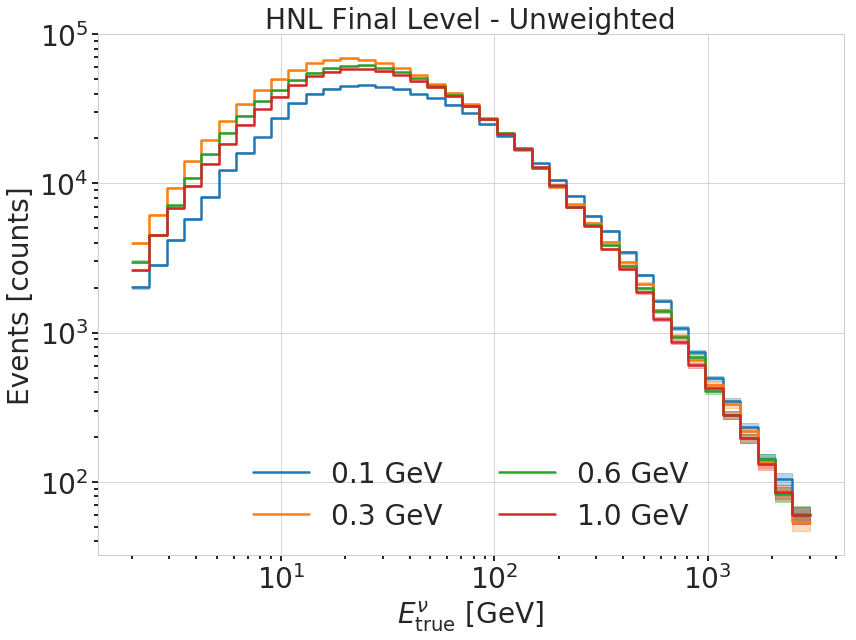

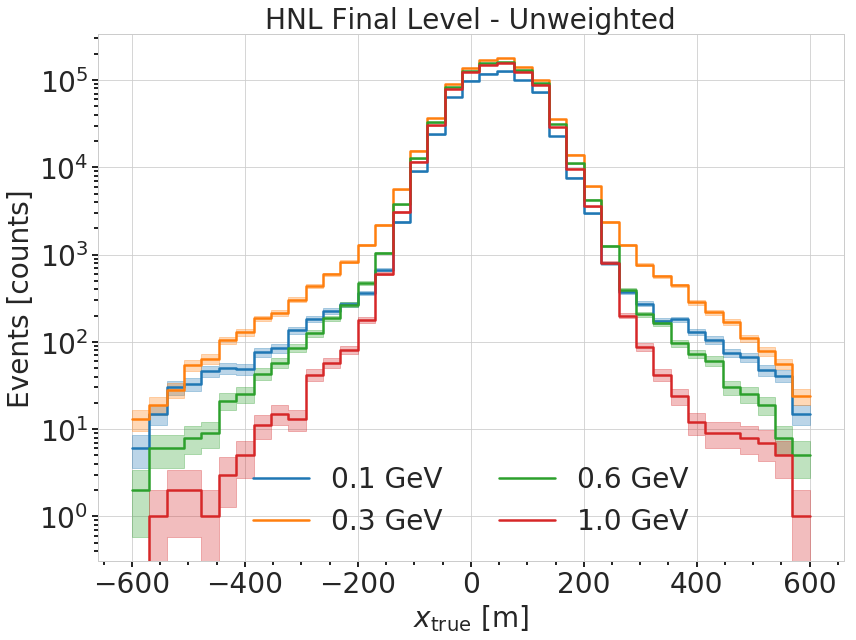

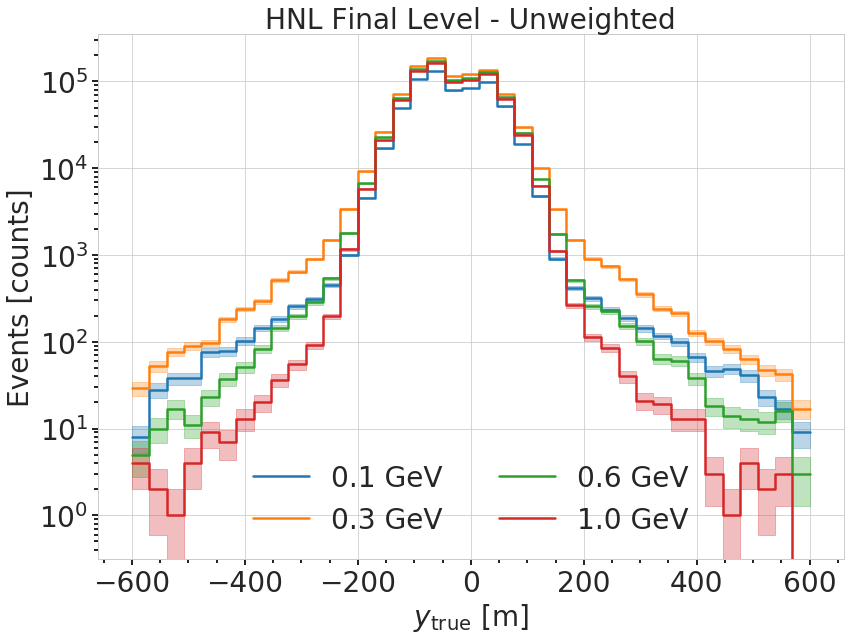

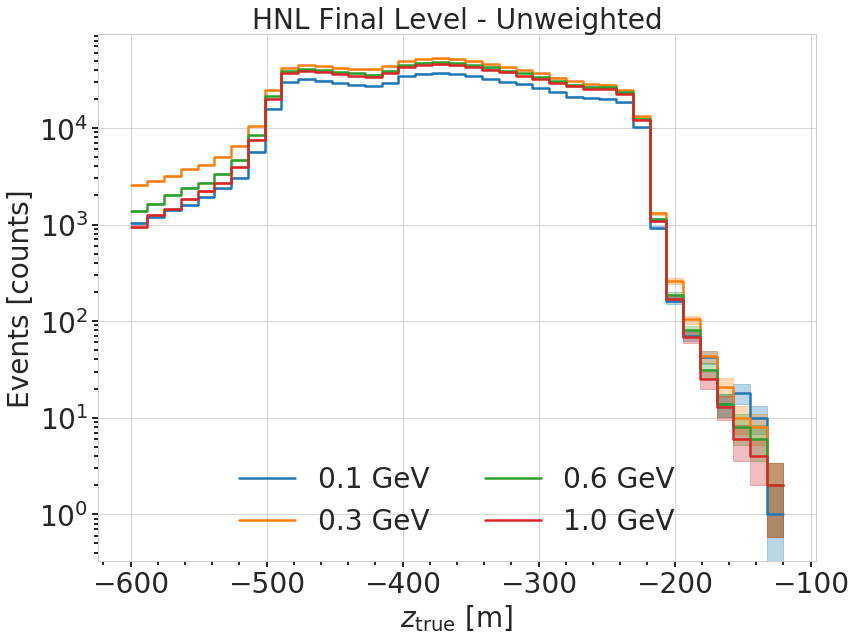

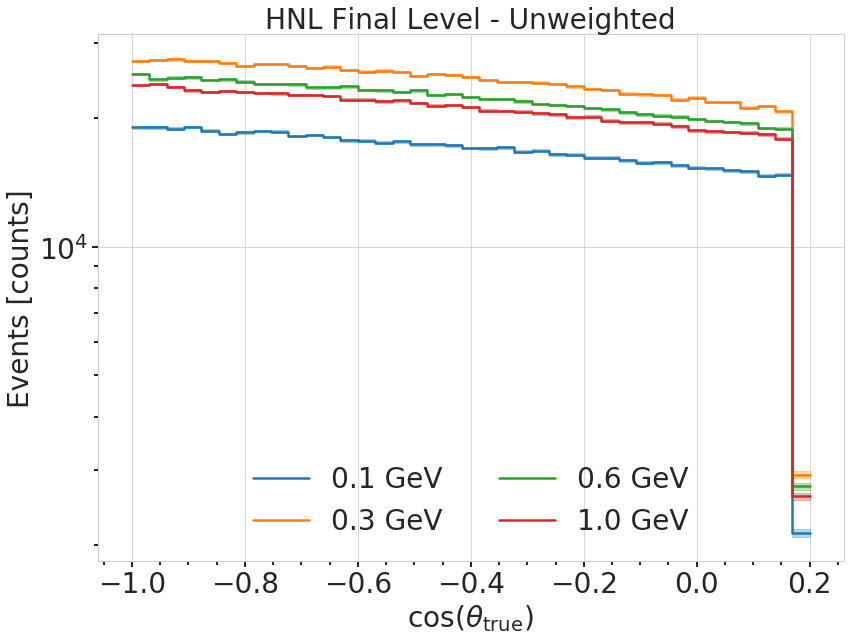

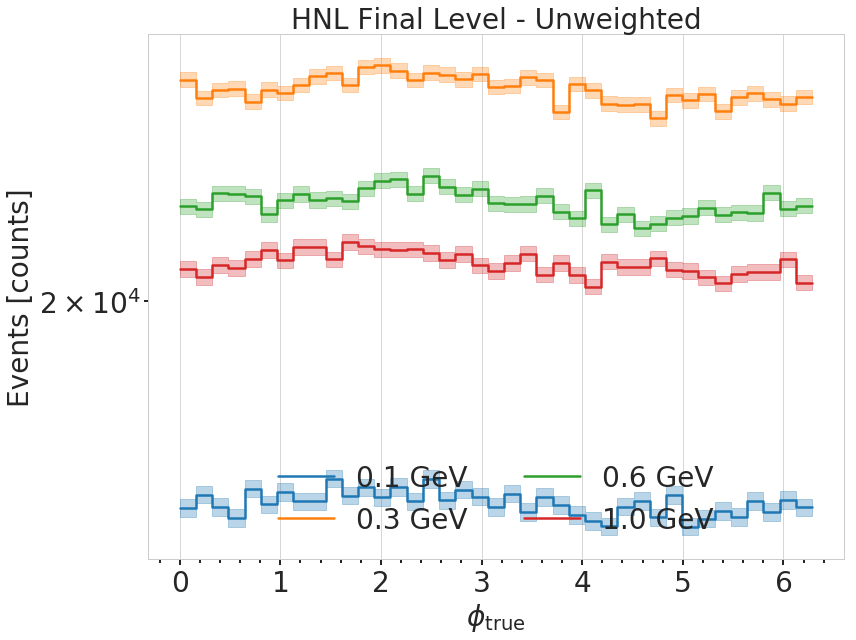

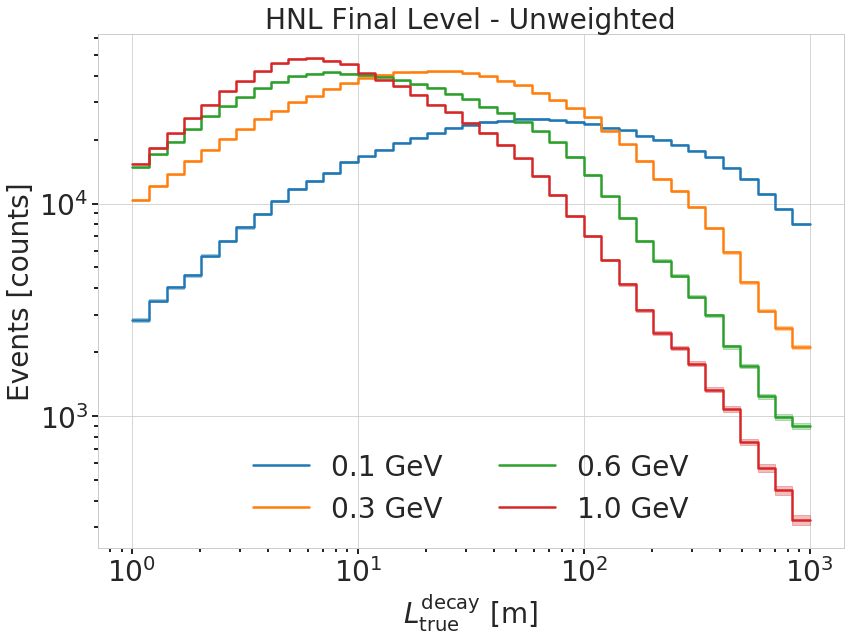

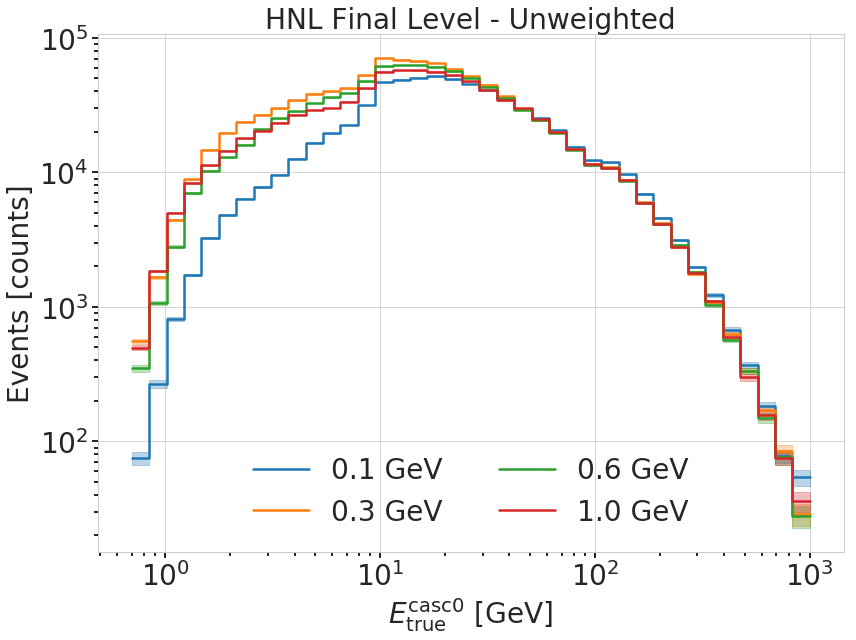

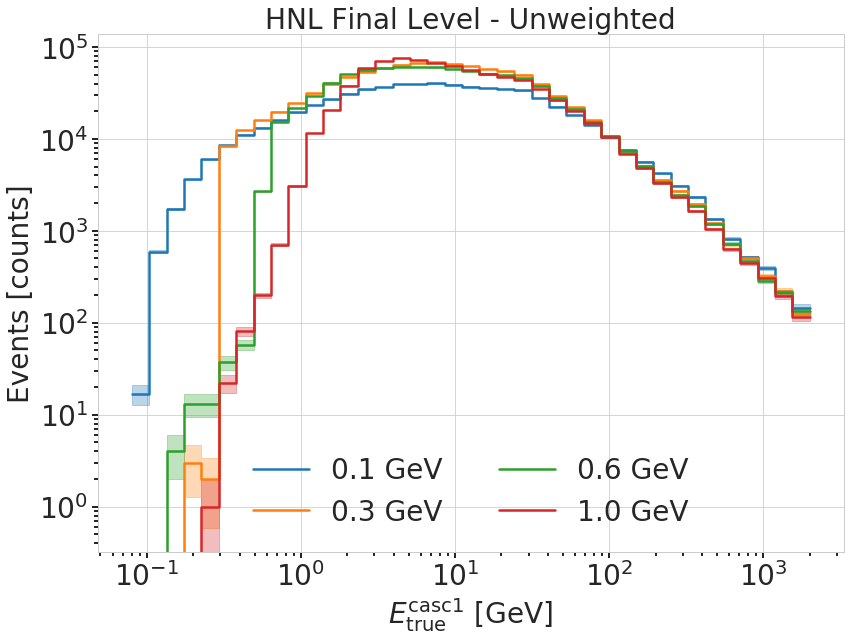

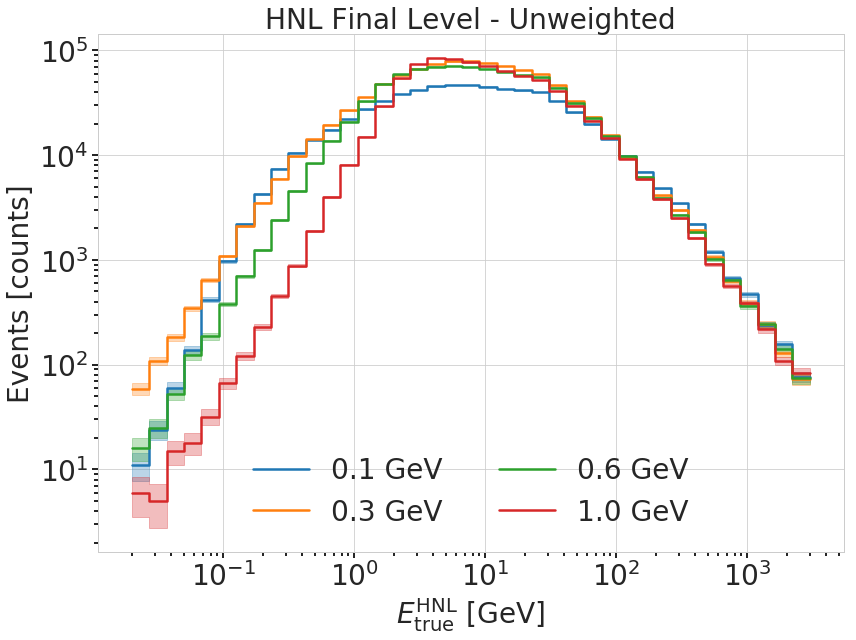

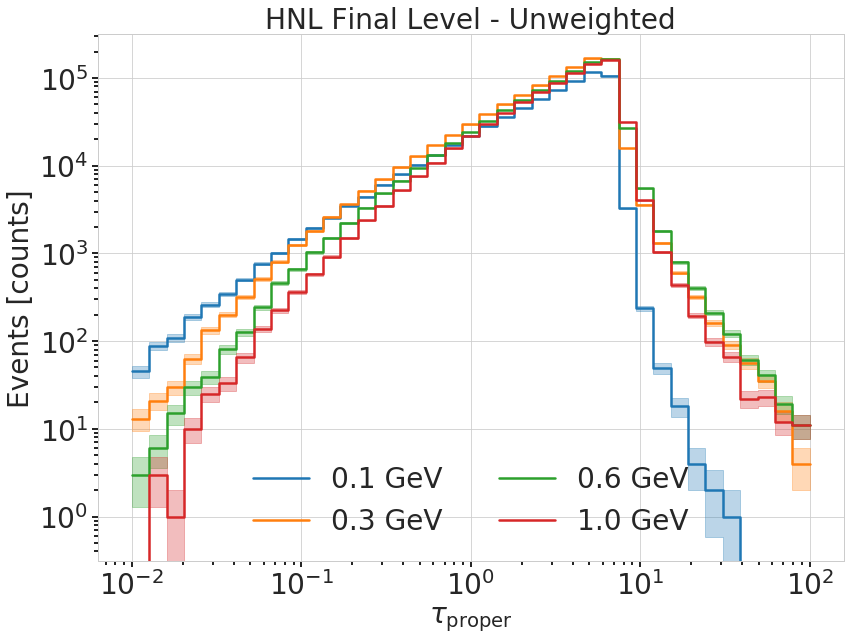

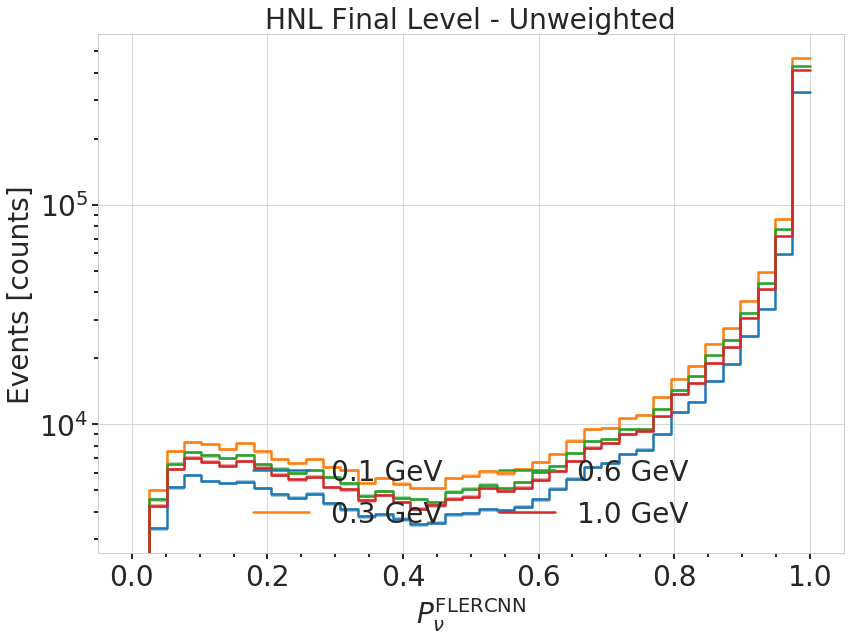

In [17]:
%%time

only_plot = [
]

weight_key = 'ReferenceWeight_1e-03'
weight_label = r'$|U_{\tau4}|^2=10^{-03}$'

clip = False

scale_bins = False

N_test = 10000
# N_test = None

# for weighted in [True, False]:
for weighted in [False]:
# for weighted in [True]:
    
    for plot_var in plot_variables:
        
#         if plot_var not in only_plot: continue
        print(plot_var)

        if(weighted):

            fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,9))
            
            for sim_set, dataframe in simset_data.items():
#                 print(sim_set)
                
                if clip:
                    counts=np.clip(dataframe[plot_var], plot_bins[plot_var][0], plot_bins[plot_var][-1])
                else:
                    if N_test:
                        counts=(dataframe[plot_var][:N_test])
                    else:
                        counts=(dataframe[plot_var])
                
                if N_test:
                    weight = dataframe[weight_key][:N_test] * weight_scale  # scale for number of files used
                else:
                    weight = dataframe[weight_key] * weight_scale  # scale for number of files used

#                 filter events with nan weight
                counts = counts[np.logical_not(np.isnan(dataframe[weight_key]))]
                weight = weight[np.logical_not(np.isnan(dataframe[weight_key]))]
                
                n, _ = np.histogram(
                    counts,
                    bins=plot_bins[plot_var],
                    weights=weight
                )

    #             divide by bin width
                if scale_bins:
                    n_binscaled = n.astype('float') / (plot_bins[plot_var][1:] - plot_bins[plot_var][:-1])
                else:
                    n_binscaled = n

                hist_ext = np.concatenate((n_binscaled, [n_binscaled[-1]]))

                ax.step(
                    plot_bins[plot_var],
                    hist_ext, 
                    where='post', 
                    lw=2.5, 
                    color=set_colors[sim_set], 
                    label='{} GeV'.format(set_mass_relation[sim_set]),
                )

                errors, _ = np.histogram(counts,
                                         bins=plot_bins[plot_var],
                                         weights=weight**2
                                         )

                errors = np.sqrt(errors)  # mc errors
                
#                 print(np.sum(n_binscaled))

    #             divide by bin width
                if scale_bins:
                    errors_binscaled = errors.astype('float') / (plot_bins[plot_var][1:] - plot_bins[plot_var][:-1])
                else:
                    errors_binscaled = errors

                errs_ext = np.concatenate((errors_binscaled, [errors_binscaled[-1]]))

                ax.fill_between(
                    plot_bins[plot_var], 
                    hist_ext-errs_ext, 
                    hist_ext+errs_ext, 
                    color=set_colors[sim_set], 
                    step='post', 
                    alpha=.3)

#                 specific plot style
                ax.set_title('HNL Final Level - Weighted ({})'.format(weight_label))
                ax.set_ylabel(r'Rate [Hz]')
                if plot_var in y_lims_weighted:
                    ax.set_ylim(y_lims_weighted[plot_var])
                
#                 just one sim set
#                 break

        else:

            fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,9))
            
            for sim_set, dataframe in simset_data.items():
#                 print(sim_set)
                
                if clip:
                    counts=np.clip(dataframe[plot_var], plot_bins[plot_var][0], plot_bins[plot_var][-1])
                else:
                    if N_test:
                        counts=(dataframe[plot_var][:N_test])
                    else:
                        counts=(dataframe[plot_var])

                n, _ = np.histogram(
                    counts,
                    bins=plot_bins[plot_var],
                )

    #             divide by bin width
                if scale_bins:
                    n_binscaled = n.astype('float') / (plot_bins[plot_var][1:] - plot_bins[plot_var][:-1])
                else:
                    n_binscaled = n


                hist_ext = np.concatenate((n_binscaled, [n_binscaled[-1]]))

                ax.step(
                    plot_bins[plot_var],
                    hist_ext, 
                    where='post', 
                    lw=2.5, 
                    color=set_colors[sim_set], 
                    label='{} GeV'.format(set_mass_relation[sim_set]),
                ) 

                errors = np.sqrt(n_binscaled)  # mc errors

                errs_ext = np.concatenate((errors, [errors[-1]]))

                ax.fill_between(
                    plot_bins[plot_var], 
                    hist_ext-errs_ext, 
                    hist_ext+errs_ext, 
                    color=set_colors[sim_set], 
                    step='post', 
                    alpha=.3
                )
                
#                 specific plot style
                ax.set_title('HNL Final Level - Unweighted')
                ax.set_ylabel(r'Events [counts]')
                if plot_var in y_lims_unweighted:
                    ax.set_ylim(y_lims_unweighted[plot_var])
                
#                 just one sim set
#                 break
        
        
#         combined style
        ax.set_xlabel(plot_labels[plot_var])

        if plot_var in x_scale_log:
            ax.set_xscale('log')
        if plot_var in y_scale_log:
            ax.set_yscale('log')

        ax.legend(
            ncol=2,
            loc='lower center',
            fontsize=28,
        )

        ax.minorticks_on()

        fig.tight_layout()

        filename = '1_d_distr_{}_final_level.png'.format(plot_var)

        plot_dir = base_plot_dir

        if not weighted:
            plot_dir = os.path.join(plot_dir, 'unweighted')
            if not os.path.isdir(plot_dir):os.makedirs(plot_dir)
            filename = filename.replace('.png', '_unweighted.png')
            filepath = os.path.join(plot_dir,filename)
        else:
            plot_dir = os.path.join(plot_dir, 'weighted_{}'.format(weight_key))
            if not os.path.isdir(plot_dir):os.makedirs(plot_dir)
            filename = filename.replace('.png', '_weighted_{}.png'.format(weight_key))

        filepath = os.path.join(plot_dir,filename)

        print(filepath)
#         fig.savefig(filepath, dpi=300)

#         just first plot_var
        break

## Cells to read in new files/convert fo feather file.. this takes some time

### Read/convert (subset of) gen level hdf5 files - commented out because feather files can be used

In [4]:
# define base path for this set
sim_base_dir = '/data/ana/BSM/HNL/MC/'  # should work for any set

In [5]:
# subset = 100  # extract more keys for plotting
subset = 1000  # extract more keys for plotting
# subset = None  # fet all

# dict for infilepaths
infiles = OrderedDict(zip(sim_sets, [list() for _ in sim_sets]))

# get the infilepaths
for key, item in infiles.items():
#     print(key)

    if key == '190610':
        these_infiles = sorted(glob.glob(os.path.join(sim_base_dir, '{}/L8/domeff1.00/*/*.hdf5'.format('190610_work_around_directory_permission_issue'))))
    else:
        these_infiles = sorted(glob.glob(os.path.join(sim_base_dir, '{}/L8/domeff1.00/*/*.hdf5'.format(key))))
    
    if subset:
        item.extend(these_infiles[:subset])
    else:
        item.extend(these_infiles)
    
#     print(item)
#     break

# print(infiles)

In [6]:
# # just get weight to reduce runtime and take more files (~30 min for 50 files)
# keys_to_extract = [    
#     "ReferenceWeight_1e-03",
# ]


# # extract more keys for plotting, but reduce number of files
# keys_to_extract = [
#     'true_energy',

#     'true_x',
#     'true_y',
#     'true_z',

#     'true_zenith',
#     'true_azimuth',
    
#     'distance',
#     'decay_channel',
    
#     'casc0_true_energy',
#     'casc1_true_energy',
    
#     'finalStateX',
#     'finalStateY',
    
#     'HNL_true_energy',
    
#     "ReferenceWeight_1e-03",
# ]


# keys_to_extract = [
# #     'L6_SANTA_FitTrack_SS_Particle',
# #     'L5_WideCorridorCutTrack',
# #     'L4_VICH_nch',
#     'casc0_true_zenith',
#     'casc0_true_energy',
#     'casc1_true_y',
#     'casc1_true_x',
# #     'L6_SANTA_FitType',
#     'HNL_true_energy',
# #     'L4_separation_in_cogs',
# #     'L5_SANTA_DirectPulsesHitStatistics',
# #     'L4_first_hlc',
#     'decay_channel',
# #     'L6_CorridorCutTrack',
# #     'L6_SANTA_PID_MS',
#     'LifetimeWeight_1e-03',
# #     'L4_MuonClassifier_MuonGun_ProbNu',
# #     'L6_CorridorCutPulses',
#     'true_zenith',
# #     'L4_VICH_npulses',
# #     'L6_CorridorCutCount',
# #     'L6_SANTA_sel_Particle',
# #     'L5_DirectHitsD',
# #     'SPEFit2',
#     'true_y',
# #     'L5_DirectHitsC',
# #     'L5_DirectHitsB',
#     'casc1_true_z',
# #     'SRTTWOfflinePulsesDCHitMultiplicity',
#     'lifetime',
# #     'SPEFit2FitParams',
# #     'L5_SANTA_DirectPulsesTimeCharacteristics',
#     'true_z',
# #     'L4_iLineFitParams',
# #     'SPEFit2_DC',
# #     'SRTTWOfflinePulsesDC',
# #     'L4_MuonClassifier_Data_ProbNu',
# #     'L4_oscNext_bool',
# #     'L5_oscNext_bool',
# #     'nan_decay_energy',
#     'FLERCNN_BDT_ProbNu',
# #     'L6_SANTA_FitTrack_SS',
#     'HNL_true_azimuth',
# #     'SRTTWOfflinePulsesDCHitStatistics',
#     'casc1_true_energy',
#     'casc0_true_azimuth',
#     'casc0_true_x',
#     'casc0_true_y',
#     'casc0_true_z',
#     'true_x',
#     'casc1_true_time',
# #     'L5_BrStrPos',
# #     'L6_SANTA_FitTrack_SS_Contained_Particle',
#     'mHNL',
# #     'L5_BrStrRho',
# #     'L6_SANTA_FitCascade_MS',
# #     'L4_first_hlc_rho',
#     'casc1_true_zenith',
# #     'outgoing_neutrino_energy',
# #     'L4_ToI',
#     'true_time',
# #     'L5_WideCorridorCutTrack_L5_SPEFit11_angles',
# #     'L6_SANTA_FitTrack_MS_Contained',
#     'totalEnergy',
# #     'L4_QR_Box',
# #     'I3MCWeightDict',
# #     'L6_SANTA_FitCascade_MS_Particle',
# #     'L5_SANTA_DirectPulsesHitMultiplicity',
# #     'SplitInIcePulses',
# #     'IC2018_LE_L3_bools',
# #     'L4_NoiseClassifier_ProbNu',
# #     'L5_WideCorridorCutPulses',
# #     'L5_VertexGuessRho',
# #     'L6_oscNext_bool',
#     'HNL_true_time',
#     'ReferenceWeight_1e-03',
# #     'L6_SANTA_FitTrack_MS_Contained_Particle',
# #     'SplitInIcePulsesHitMultiplicity',
# #     'L6_SANTA_FitCascade_SS',
# #     'I3EventHeader',
#     'true_energy',
# #     'L6_SANTA_sel',
# #     'L6_SANTA_FitTrack_MS_Particle',
#     'distance',
#     'true_azimuth',
# #     'L6_SANTA_PID_SS',
# #     'L5_WideCorridorCutPulsesTimeCharacteristics',
# #     'L4_VICH_qtot',
# #     'L3_oscNext_bool',
# #     'SplitInIcePulsesTimeCharacteristics',
# #     'IC2018_LE_L3_Vars',
# #     'L5_WideCorridorCutPulsesHitStatistics',
# #     'L4_NoiseStraightCuts_Bool',
#     'HNL_true_z',
#     'HNL_true_x',
#     'HNL_true_y',
# #     'L5_WideCorridorCutPulsesHitMultiplicity',
#     'finalStateX',
#     'finalStateY',
# #     'L5_SPEFit11',
# #     'L4_micro_count',
# #     'L6_SANTA_FitTrack_MS',
#     'HNL_true_zenith',
#     'physical',
#     'casc0_true_time',
# #     'L6_SANTA_FitTrack_SS_Contained',
# #     'I3MCTree',
#     'LeptonInjectorWeight',
# #     'L4_fill_ratio',
# #     'SRTTWOfflinePulsesDCTimeCharacteristics',
#     'final_state_particle0',
#     'final_state_particle1',
# #     'L6_SANTA_LineFit',
# #     'L4_ToIParams',
#     'distanceMin',
#     'primary_type',
# #     'L5_SANTA_DirectPulses',
# #     'L6_SANTA_sel_PID',
# #     'L4_iLineFit',
# #     'casc1_true_azimuth',
# #     'SplitInIcePulsesHitStatistics',
# #     'L4_accumulated_time',
# #     'FilterMask',
# #     'total_column_depth',
# #     'SPEFit2_DCFitParams',
# #     'L5_DirectHitsA',
#     'OneWeight',
# #     'L5_WideCorridorCutCount',
#     'distanceMax',
# #     'I3TriggerHierarchy'
#  ]

# reduce to extract all files:
keys_to_extract = [
#     'L6_SANTA_FitTrack_SS_Particle',
#     'L5_WideCorridorCutTrack',
#     'L4_VICH_nch',
#     'casc0_true_zenith',
    'casc0_true_energy',
#     'casc1_true_y',
#     'casc1_true_x',
#     'L6_SANTA_FitType',
    'HNL_true_energy',
#     'L4_separation_in_cogs',
#     'L5_SANTA_DirectPulsesHitStatistics',
#     'L4_first_hlc',
#     'decay_channel',
#     'L6_CorridorCutTrack',
#     'L6_SANTA_PID_MS',
    'LifetimeWeight_1e-03',
#     'L4_MuonClassifier_MuonGun_ProbNu',
#     'L6_CorridorCutPulses',
    'true_zenith',
#     'L4_VICH_npulses',
#     'L6_CorridorCutCount',
#     'L6_SANTA_sel_Particle',
#     'L5_DirectHitsD',
#     'SPEFit2',
    'true_y',
#     'L5_DirectHitsC',
#     'L5_DirectHitsB',
#     'casc1_true_z',
#     'SRTTWOfflinePulsesDCHitMultiplicity',
    'lifetime',
#     'SPEFit2FitParams',
#     'L5_SANTA_DirectPulsesTimeCharacteristics',
    'true_z',
#     'L4_iLineFitParams',
#     'SPEFit2_DC',
#     'SRTTWOfflinePulsesDC',
#     'L4_MuonClassifier_Data_ProbNu',
#     'L4_oscNext_bool',
#     'L5_oscNext_bool',
#     'nan_decay_energy',
    'FLERCNN_BDT_ProbNu',
#     'L6_SANTA_FitTrack_SS',
#     'HNL_true_azimuth',
#     'SRTTWOfflinePulsesDCHitStatistics',
    'casc1_true_energy',
#     'casc0_true_azimuth',
#     'casc0_true_x',
#     'casc0_true_y',
#     'casc0_true_z',
    'true_x',
#     'casc1_true_time',
#     'L5_BrStrPos',
#     'L6_SANTA_FitTrack_SS_Contained_Particle',
    'mHNL',
#     'L5_BrStrRho',
#     'L6_SANTA_FitCascade_MS',
#     'L4_first_hlc_rho',
#     'casc1_true_zenith',
#     'outgoing_neutrino_energy',
#     'L4_ToI',
#     'true_time',
#     'L5_WideCorridorCutTrack_L5_SPEFit11_angles',
#     'L6_SANTA_FitTrack_MS_Contained',
#     'totalEnergy',
#     'L4_QR_Box',
#     'I3MCWeightDict',
#     'L6_SANTA_FitCascade_MS_Particle',
#     'L5_SANTA_DirectPulsesHitMultiplicity',
#     'SplitInIcePulses',
#     'IC2018_LE_L3_bools',
#     'L4_NoiseClassifier_ProbNu',
#     'L5_WideCorridorCutPulses',
#     'L5_VertexGuessRho',
#     'L6_oscNext_bool',
#     'HNL_true_time',
    'ReferenceWeight_1e-03',
#     'L6_SANTA_FitTrack_MS_Contained_Particle',
#     'SplitInIcePulsesHitMultiplicity',
#     'L6_SANTA_FitCascade_SS',
#     'I3EventHeader',
    'true_energy',
#     'L6_SANTA_sel',
#     'L6_SANTA_FitTrack_MS_Particle',
    'distance',
    'true_azimuth',
#     'L6_SANTA_PID_SS',
#     'L5_WideCorridorCutPulsesTimeCharacteristics',
#     'L4_VICH_qtot',
#     'L3_oscNext_bool',
#     'SplitInIcePulsesTimeCharacteristics',
#     'IC2018_LE_L3_Vars',
#     'L5_WideCorridorCutPulsesHitStatistics',
#     'L4_NoiseStraightCuts_Bool',
#     'HNL_true_z',
#     'HNL_true_x',
#     'HNL_true_y',
#     'L5_WideCorridorCutPulsesHitMultiplicity',
#     'finalStateX',
#     'finalStateY',
#     'L5_SPEFit11',
#     'L4_micro_count',
#     'L6_SANTA_FitTrack_MS',
#     'HNL_true_zenith',
#     'physical',
#     'casc0_true_time',
#     'L6_SANTA_FitTrack_SS_Contained',
#     'I3MCTree',
    'LeptonInjectorWeight',
#     'L4_fill_ratio',
#     'SRTTWOfflinePulsesDCTimeCharacteristics',
#     'final_state_particle0',
#     'final_state_particle1',
#     'L6_SANTA_LineFit',
#     'L4_ToIParams',
#     'distanceMin',
#     'primary_type',
#     'L5_SANTA_DirectPulses',
#     'L6_SANTA_sel_PID',
#     'L4_iLineFit',
#     'casc1_true_azimuth',
#     'SplitInIcePulsesHitStatistics',
#     'L4_accumulated_time',
#     'FilterMask',
#     'total_column_depth',
#     'SPEFit2_DCFitParams',
#     'L5_DirectHitsA',
#     'OneWeight',
#     'L5_WideCorridorCutCount',
#     'distanceMax',
#     'I3TriggerHierarchy'
 ]

# (sorted(keys_to_extract))

In [7]:
# %%time

# # uncomment to extract data from hdf5 and store to feather

# # read in the hdf5files and store the dataframes
# simset_data = OrderedDict()

# for key, item in infiles.items():
#     print(key)
    
#     if subset:
#         outpath = '/data/ana/BSM/HNL/MC/feather_files/final_level/{}_final_level_{}_files_subset.feather'.format(key, subset)
#     else:
#         outpath = '/data/ana/BSM/HNL/MC/feather_files/final_level/{}_final_level.feather'.format(key)
                
#     print(outpath)
    
# #     simset_data[key] = hdf5_to_feather(
#     hdf5_to_feather(  # don't store for speedup
#         item,
#         keys=keys_to_extract,
#         outfilepath=outpath,
#     )
    
# #     break

INFO:root:Keys to be extracted: ['mHNL', 'distance', 'HNL_true_energy', 'true_zenith', 'casc1_true_energy', 'casc0_true_energy', 'FLERCNN_BDT_ProbNu', 'LeptonInjectorWeight', 'true_z', 'true_azimuth', 'lifetime', 'true_y', 'true_x', 'true_energy', 'ReferenceWeight_1e-03']


190611
/data/ana/BSM/HNL/MC/feather_files/final_level/190611_final_level_1000_files_subset.feather


100%|██████████| 1000/1000 [29:04<00:00,  1.74s/it]
INFO:root:Keys to be extracted: ['mHNL', 'distance', 'HNL_true_energy', 'true_zenith', 'casc1_true_energy', 'casc0_true_energy', 'FLERCNN_BDT_ProbNu', 'LeptonInjectorWeight', 'true_z', 'true_azimuth', 'lifetime', 'true_y', 'true_x', 'true_energy', 'ReferenceWeight_1e-03']


190612
/data/ana/BSM/HNL/MC/feather_files/final_level/190612_final_level_1000_files_subset.feather


100%|██████████| 1000/1000 [35:46<00:00,  2.15s/it]


CPU times: user 2min 31s, sys: 22.6 s, total: 2min 53s
Wall time: 1h 4min 59s
